In [97]:
import tensorflow as tf
import numpy as np
import data
import matplotlib.pyplot as plt
from matplotlib.colors import  ListedColormap
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix

In [98]:
def count_params():
    total = 0
    for var in tf.trainable_variables():
        shape = var.get_shape()
        var_params = int(np.prod(shape))
        print('{}; shape: {}; total: {}'.format(var.name, shape, var_params))
        total += var_params
    print('Total:', total)
    

import itertools

    
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [99]:
NUM_EXAMPLES = 10
CLASSES = 3
DISTRIBUTIONS = 6
SEED = 106

In [100]:
class TFDeep:
    """
        Class that represents a deep neural network implementation in tensorflow.
    """

    def __init__(self, shapes, param_delta=0.1, param_lambda=0.01, activation=tf.nn.relu):
        """Arguments:
           - D: dimensions of each datapoint
           - C: number of classes
           - param_delta: training step
        """
        tf.reset_default_graph()
        self.X = tf.placeholder(dtype=tf.float32, shape=[None, shapes[0]])
        self.Yoh_ = tf.placeholder(dtype=tf.float32, shape=[None, shapes[-1]])

        self.weights = []
        self.biases = []
        self.hs = []

        for i, shape in enumerate(shapes[1:]):
            self.weights.append(tf.Variable(initial_value=tf.random_normal([shapes[i], shape]), name='W%s' % i))
            self.biases.append(tf.Variable(initial_value=tf.random_normal([1, shape]), name='b%s' % i))

        # NN input
        self.hs.append(activation(tf.matmul(self.X, self.weights[0]) + self.biases[0]))

        # NN inner connections
        for i in range(1, len(shapes[1:-1])):
            self.hs.append(activation(tf.matmul(self.hs[-1], self.weights[i]) + self.biases[i]))

        # NN output
        if len(shapes[1:-1]) == 0:
            # regular logistic regression
            output = tf.matmul(self.X, self.weights[-1]) + self.biases[-1]
        else:
            # neural network last layer output
            output = tf.matmul(self.hs[-1], self.weights[-1]) + self.biases[-1]

        self.probs = tf.nn.softmax(output)

        self.cross_entropy = tf.reduce_mean(-tf.reduce_sum(self.Yoh_ * tf.log(self.probs + 1e-8), axis=1))
        self.regularization = [param_lambda * tf.nn.l2_loss(weights) for weights in self.weights]
        self.loss = self.cross_entropy + tf.add_n(self.regularization)

        self.train_step = tf.train.GradientDescentOptimizer(param_delta).minimize(self.loss)

        self.session = tf.Session()

    def train(self, X, Yoh_, param_niter):
        """Arguments:
           - X: actual datapoints [NxD]
           - Yoh_: one-hot encoded labels [NxC]
           - param_niter: number of iterations
        """
        self.session.run(tf.global_variables_initializer())

        for i in range(param_niter+1):
            tr = self.session.run([self.train_step], feed_dict={self.X: X, self.Yoh_: Yoh_})
            if i % 1000 == 0:
                loss = self.session.run(self.loss, feed_dict={self.X: X, self.Yoh_: Yoh_})
                print("{0:4}. Loss: {1:.8f}".format(i, loss))

    def eval(self, X):
        """Arguments:
           - X: actual datapoints [NxD]
           Returns: predicted class probabilites [NxC]
        """
        probs = self.session.run(self.probs, feed_dict={self.X: X})
        return probs

    def classify(self, X):
        return np.argmax(self.eval(X), axis=1)

    def eval_perf(self, Y, Y_):
        # needed to compute scores of our model
        # 'weighted' takes into consideration labels imbalance
        classes = max(int(max(Y_) + 1), int(max(Y) + 1))
        if  classes == 2:
            average = 'binary'
        else:
            average = 'weighted'

        accuracy = accuracy_score(Y_, Y)
        precision = precision_score(Y_, Y, average=average)
        recall = recall_score(Y_, Y, average=average)
        f1 = f1_score(Y_, Y, average=average)

        print("Accuracy: {0:.3f}\n"
              "Precision: {1:.3f}\n"
              "Recall: {2:.3f}\n"
              "F1: {3:.3f} ".format(accuracy, precision, recall, f1))
        plot_confusion_matrix(confusion_matrix(Y_, Y), classes=range(0, classes))
        plt.show()

In [101]:
np.random.seed(SEED)
tf.set_random_seed(SEED)
X, Y_ = data.sample_gmm_2d(DISTRIBUTIONS, CLASSES, NUM_EXAMPLES)

In [102]:
Yoh_ = Y_.reshape(-1)
Yoh_ = np.eye(CLASSES)[Yoh_]

In [103]:
shape = [2, 10, 15,CLASSES]

tfdeep = TFDeep(shape, param_delta=0.01, param_lambda=0.01)

In [104]:
tfdeep.train(X, Yoh_, 20000)

   0. Loss: 4.49927378
1000. Loss: 1.21701324
2000. Loss: 1.05937278
3000. Loss: 0.93559420
4000. Loss: 0.83500373
5000. Loss: 0.75000572
6000. Loss: 0.68293333
7000. Loss: 0.62766910
8000. Loss: 0.58451426
9000. Loss: 0.54821122
10000. Loss: 0.51279974
11000. Loss: 0.48175904
12000. Loss: 0.45307583
13000. Loss: 0.42781946
14000. Loss: 0.40773287
15000. Loss: 0.39225352
16000. Loss: 0.38065499
17000. Loss: 0.37170780
18000. Loss: 0.36464787
19000. Loss: 0.35894519
20000. Loss: 0.35423025


In [105]:
probs = tfdeep.eval(X)
print("Predicted:\n", np.argmax(probs, axis=1))
print("True:\n",Y_.flatten())

Predicted:
 [2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 0 2 0 2 2 2 0 2 0 2 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
True:
 [2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


Accuracy: 0.917
Precision: 0.922
Recall: 0.917
F1: 0.916 


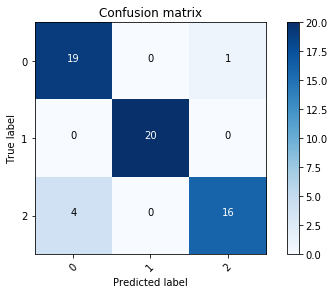

W0:0; shape: (2, 10); total: 20
b0:0; shape: (1, 10); total: 10
W1:0; shape: (10, 15); total: 150
b1:0; shape: (1, 15); total: 15
W2:0; shape: (15, 3); total: 45
b2:0; shape: (1, 3); total: 3
Total: 243


In [106]:
tfdeep.eval_perf(np.argmax(probs, axis=1), np.argmax(Yoh_, axis=1))
count_params()

   0. Loss: 3.35476351
1000. Loss: 1.57796311
2000. Loss: 1.36703348
3000. Loss: 1.21774125
4000. Loss: 1.10939527
5000. Loss: 1.02687359
6000. Loss: 0.96347773
7000. Loss: 0.91375542
8000. Loss: 0.87375695
9000. Loss: 0.84095871
10000. Loss: 0.81412303
11000. Loss: 0.79236853
12000. Loss: 0.77459586
13000. Loss: 0.75993633
14000. Loss: 0.74776059
15000. Loss: 0.73758686
16000. Loss: 0.72903717
17000. Loss: 0.72181320
18000. Loss: 0.71567881
19000. Loss: 0.71044642
20000. Loss: 0.70596546
Accuracy: 0.817
Precision: 0.873
Recall: 0.817
F1: 0.799 


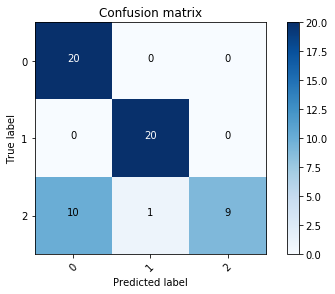

In [107]:
tfdeep_sigm = TFDeep(shape, param_delta=0.01, param_lambda=0.01, activation=tf.nn.sigmoid)
tfdeep_sigm.train(X, Yoh_, 20000)
probs_sigm = tfdeep_sigm.eval(X)
tfdeep_sigm.eval_perf(np.argmax(probs_sigm, axis=1), np.argmax(Yoh_, axis=1))

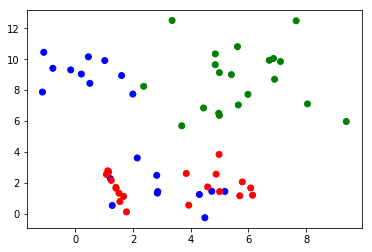

In [108]:
colors = ['red', 'green', 'blue']
plt.scatter(X[:, 0], X[:, 1], c=Y_.flatten(), cmap=ListedColormap(colors))
plt.show()

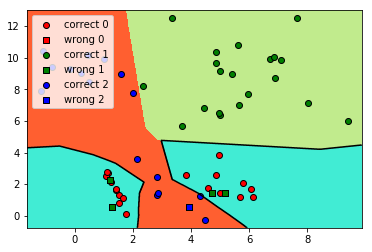

In [109]:
data.plot_decision_boundary(X, lambda x: tfdeep.classify(x))
# graph the data points
data.graph_data(X, Y_, np.argmax(probs, axis=1))

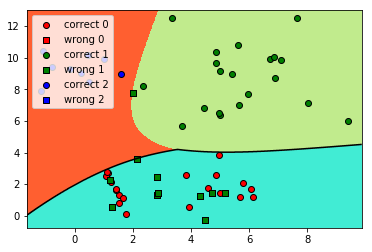

In [110]:
data.plot_decision_boundary(X, lambda x: tfdeep_sigm.classify(x))
# graph the data points
data.graph_data(X, Y_, np.argmax(probs_sigm, axis=1))

In [111]:
SEED = 105
np.random.seed(SEED)
tf.set_random_seed(SEED)
X2, Y_2 = data.sample_gmm_2d(DISTRIBUTIONS, CLASSES, NUM_EXAMPLES)

In [112]:
Yoh_2 = Y_2.reshape(-1)
Yoh_2 = np.eye(CLASSES)[Yoh_2]

In [113]:
tfdeep2 = TFDeep(shape, param_delta=0.03, param_lambda=0.01)

In [114]:
tfdeep2.train(X2, Yoh_2, 20000)

   0. Loss: 12.62504005
1000. Loss: 0.85344613
2000. Loss: 0.63070130
3000. Loss: 0.51506627
4000. Loss: 0.45453629
5000. Loss: 0.42131141
6000. Loss: 0.40073395
7000. Loss: 0.38839412
8000. Loss: 0.38051656
9000. Loss: 0.37463793
10000. Loss: 0.36767089
11000. Loss: 0.36253023
12000. Loss: 0.35899338
13000. Loss: 0.35623562
14000. Loss: 0.35374135
15000. Loss: 0.35143745
16000. Loss: 0.34776348
17000. Loss: 0.34548771
18000. Loss: 0.34364694
19000. Loss: 0.34201646
20000. Loss: 0.34016222


In [115]:
probs2 = tfdeep2.eval(X2)
print("Predicted:\n", np.argmax(probs2, axis=1))
print("True:\n",Y_2.flatten())

Predicted:
 [2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 2 2 2 0 2 2 0 2 2 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
True:
 [2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Accuracy: 0.933
Precision: 0.936
Recall: 0.933
F1: 0.933 


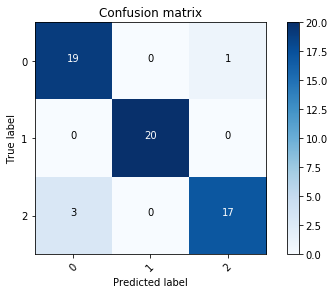

In [116]:
tfdeep2.eval_perf(np.argmax(probs2, axis=1), np.argmax(Yoh_2, axis=1))

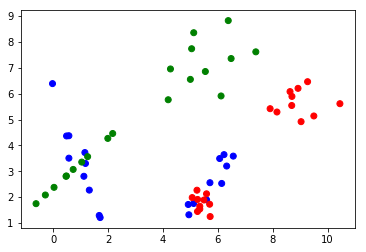

In [117]:
plt.scatter(X2[:, 0], X2[:, 1], c=Y_2.flatten(), cmap=ListedColormap(colors))
plt.show()

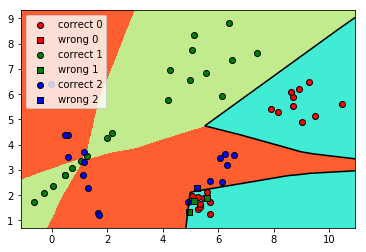

In [118]:
data.plot_decision_boundary(X2, lambda x: tfdeep2.classify(x))
# graph the data points
data.graph_data(X2, Y_2, np.argmax(probs2, axis=1))

In [119]:
count_params()

W0:0; shape: (2, 10); total: 20
b0:0; shape: (1, 10); total: 10
W1:0; shape: (10, 15); total: 150
b1:0; shape: (1, 15); total: 15
W2:0; shape: (15, 3); total: 45
b2:0; shape: (1, 3); total: 3
Total: 243
